<a href="https://colab.research.google.com/github/Labib666Camp/ECG-Classification-With-Wavelet-Preprocessing/blob/master/cd_wavelet_ECG_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here, I am using the MITBh ECG dataset. It can be found in the link given in the readme file.


In [ ]:
import pandas as pd
df1 = pd.read_csv('/content/drive/My Drive/mitbih_train.csv')
df2 = pd.read_csv('/content/drive/My Drive/mitbih_test.csv')

Checking the number of columns and resrating their datatype as string, also renaming the columns neumerically in an ascending order


In [ ]:
new_cols = []
_, y = df1.shape
for i in range(y):
  new_cols.append(i)
df1.columns = new_cols
df2.columns = new_cols
df2.columns = df2.columns.astype('str')
df1.columns = df1.columns.astype('str')
data = pd.concat([df1, df2], axis=0)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109444 entries, 0 to 21890
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


Quantifying the classes in the dataset 

In [ ]:
equilibre = data['187'].value_counts()
print(equilibre)
data.shape

0.0    90587
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64


(109444, 188)

Using SMOTE(Synthetic Minority Oversampling Technique) to balance out the classes

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
import numpy as np

counter = Counter(data['187'])
print(counter)

data_y = data['187']
data_x = data.drop(columns='187')

oversample = SMOTE()

data_x, data_y = oversample.fit_resample(data_x,data_y)
print(Counter(data_y))

Executing "haar" wavelet transform on the instances of the dataset. I took the Direct Coefficients and made a list out of it, which later was used as the training data for the network

In [ ]:
import pywt
import numpy as np
import pandas as pd
data_x = pd.DataFrame(data_x)
len = data_x.shape[0]
ca_data_x = []
cd_data_x = []

for i in range(len):
  cA, cD = pywt.dwt(data_x.iloc[i], 'haar')
  cA = np.array(cA)
  cD = np.array(cD)
  cd_data_x.append(cD)
  ca_data_x.append(cA)

cd_data_x = np.array(cd_data_x)
ca_data_x = np.array(ca_data_x)
cd_data_x = pd.DataFrame(cd_data_x)
ca_data_x = pd.DataFrame(ca_data_x)
cd_data_x.head



<bound method NDFrame.head of               0         1         2         3   ...   90   91   92   93
0       0.068495  0.187353 -0.022160  0.008058  ...  0.0  0.0  0.0  0.0
1       0.240799  0.082177  0.007644  0.009555  ...  0.0  0.0  0.0  0.0
2       0.183613  0.187520  0.083993  0.007813  ...  0.0  0.0  0.0  0.0
3      -0.023238  0.172627  0.076354  0.039837  ...  0.0  0.0  0.0  0.0
4      -0.051293  0.306535  0.015876 -0.007328  ...  0.0  0.0  0.0  0.0
...          ...       ...       ...       ...  ...  ...  ...  ...  ...
452930  0.054760  0.006227  0.032022  0.039276  ...  0.0  0.0  0.0  0.0
452931  0.119555  0.015241  0.027210  0.034213  ...  0.0  0.0  0.0  0.0
452932  0.082201  0.092163  0.066591  0.018994  ...  0.0  0.0  0.0  0.0
452933  0.300276  0.025410  0.030119  0.056741  ...  0.0  0.0  0.0  0.0
452934  0.031580  0.044020  0.073951  0.086410  ...  0.0  0.0  0.0  0.0

[452935 rows x 94 columns]>

Spliting the data between Train and validation sets

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

cd_train_x, cd_valid_x, train_y, valid_y = train_test_split(cd_data_x, data_y, test_size=0.33, shuffle=True)
cd_train_x = np.expand_dims(cd_train_x,2)
cd_valid_x = np.expand_dims(cd_valid_x,2)
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
train_y = ohe.fit_transform(train_y.reshape(-1,1))
valid_y = ohe.transform(valid_y.reshape(-1,1))

train_y = train_y.toarray()
valid_y = valid_y.toarray()

cd_train_x.shape

(303466, 94, 1)

In [ ]:
from keras import Sequential, Input, Model
from keras.layers import Conv1D, Dense, Activation, BatchNormalization, Dropout, Flatten

Building the network using keras 

In [ ]:
input_shape = (94,1)
input_data = Input(shape=input_shape, name='input_data')
print(input_data.shape)
cn1 = Conv1D(64,(5),strides=1, activation="relu", input_shape=input_shape)(input_data)
print(cn1.shape)
cn1 = BatchNormalization()(cn1)

cn2 = Conv1D(64,(5),strides=1, activation="relu")(cn1)
print(cn2.shape)
cn2 = BatchNormalization()(cn2)

cn3 = Conv1D(64,(5),strides=1, activation="relu")(cn2)
print(cn3.shape)
cn3 = BatchNormalization()(cn3)

flat = Flatten()(cn3)
print(flat.shape)
d1 = Dense(64, activation="relu")(flat)
print(d1.shape)
d2 = Dense(32, activation="relu")(d1)
print(d2.shape)
output_d3 = Dense(5, activation="softmax", name='d3')(d2)
print(output_d3.shape)
#assert output_d3.output_shape == (None,5)

model = Model(inputs=input_data, outputs=output_d3)
assert model.output_shape == (None,5)

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(cd_train_x, train_y, epochs=10, batch_size=32, validation_data=(cd_valid_x,valid_y))


(None, 94, 1)
(None, 90, 64)
(None, 86, 64)
(None, 82, 64)
(None, 5248)
(None, 64)
(None, 32)
(None, 5)
Epoch 1/10
9484/9484 [==============================] - 56s 6ms/step - loss: 0.1217 - accuracy: 0.9585 - val_loss: 0.3334 - val_accuracy: 0.8867
Epoch 2/10
9484/9484 [==============================] - 55s 6ms/step - loss: 0.0419 - accuracy: 0.9864 - val_loss: 0.0426 - val_accuracy: 0.9863
Epoch 3/10
9484/9484 [==============================] - 54s 6ms/step - loss: 0.0249 - accuracy: 0.9920 - val_loss: 0.0297 - val_accuracy: 0.9905
Epoch 4/10
9484/9484 [==============================] - 53s 6ms/step - loss: 0.0181 - accuracy: 0.9942 - val_loss: 2.1136 - val_accuracy: 0.7435
Epoch 5/10
9484/9484 [==============================] - 52s 5ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.1155 - val_accuracy: 0.9725
Epoch 6/10
9484/9484 [==============================] - 52s 5ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.0248 - val_accuracy: 0.9934
Epoch 7/10
9484/9484 [====

Ploting the validation and training accuracy and loss 

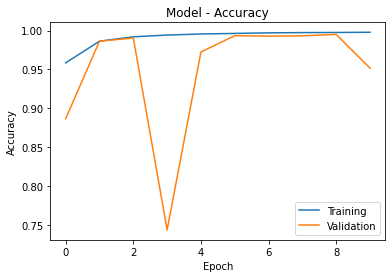

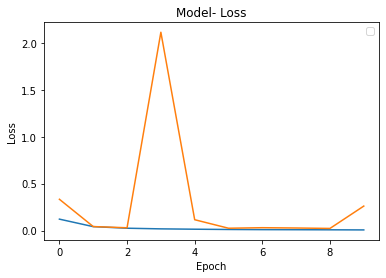

In [ ]:
fig1, ax_acc = plt.subplots()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

fig2, ax_loss = plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model- Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()